# ReLoad Data

This ipynb file consists of description of evaluation metrics used in object detection


In [1]:
import torch
torch.set_printoptions(precision=2)
##File Management

import os
import glob
import pandas as pd

#Image,Numpy
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#Img Augment
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from torchvision import transforms as T
from dataload import xml_to_csv,PetData
import random
root_path="D:/Dataset/Oxford"

img_path=os.path.join(root_path,"images")
annotation_path=os.path.join(root_path,"annotations/xmls")           
annots = glob.glob(annotation_path+"/*.xml")
df=xml_to_csv(annots,img_path)
df.head()


,filename,target,xmin,ymin,xmax,ymax
0,D:/Dataset/Oxford\images\Abyssinian_1.jpg,0,333,72,425,158
1,D:/Dataset/Oxford\images\Abyssinian_10.jpg,0,72,105,288,291
2,D:/Dataset/Oxford\images\Abyssinian_100.jpg,0,151,71,335,267
3,D:/Dataset/Oxford\images\Abyssinian_101.jpg,0,54,36,319,235
4,D:/Dataset/Oxford\images\Abyssinian_102.jpg,0,23,27,325,320


In [2]:

BATCH_SIZE = 5
train_ds = PetData(df, train=True,tensor_return=False)

def collate_fn(batch):
    return tuple(zip(*batch))
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn,shuffle=True)



## Evaluation Metrics: mAP ([Link](https://lilianweng.github.io/lil-log/2017/12/15/object-recognition-for-dummies-part-2.html#evaluation-metrics-map))
A common evaluation metric used in many object recognition and detection tasks is **“mAP”**, short for **“mean average precision”**. It is a number from 0 to 100; higher value is better.

+ Combine all detections from all test images to draw a precision-recall curve (PR curve) for each class; The “average precision” (AP) is the area under the PR curve.
+ Given that target objects are in different classes, we first compute AP separately for each class, and then average over classes.
+ A detection is a true positive if it has “intersection over union” (IoU) with a ground-truth box greater than some threshold (usually 0.5; if so, the metric is “mAP@0.5”)

[(Python으로 구현한 mAP)](https://herbwood.tistory.com/)


## Measuring IOU

In [3]:
def torch_getIntersectArea(boxA,boxB):
    #Will return none if no intersect
    dx = min(boxA[2], boxB[2]) - max(boxA[0], boxB[0])
    dy = min(boxA[3], boxB[3]) - max(boxA[1], boxB[1])

    if (dx>=0) and (dy>=0):
        return float(dx*dy)
def torch_getArea(box):
    return float((box[2] - box[0] ) * (box[3] - box[1]))
def torch_getUnion(boxA,boxB,inter_area):
    return torch_getArea(boxA)+torch_getArea(boxB)-inter_area

def torch_getIOU(boxA,boxB):
    I=torch_getIntersectArea(boxA,boxB)

    if I is None: 
        return 0
    U=torch_getUnion(boxA,boxB,I)
   # return float(I)/float(U)

    return torch.div(I,U)

In [4]:
torch_gt_box = torch.tensor((394, 124, 429, 180))
torch_pred_box =  torch.tensor((360, 100, 450, 300))

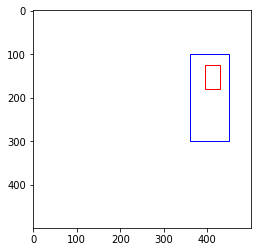

In [5]:
#Drawing Boxes on Img
def draw_box(img,boxes):
    COLOR=['red','blue']
    fig, ax = plt.subplots()
    ax.imshow(img)
    for box in  boxes:
        ax.add_patch(
     patches.Rectangle(
        (box.x1,box.y1),
        (box.x2-box.x1),
        (box.y2-box.y1),
        edgecolor = COLOR[box.label],
        fill=False ) )
    plt.show()
draw_box(np.ones((500,500,3)),[BoundingBox(*torch_gt_box,label=0),BoundingBox(*torch_pred_box,label=1)])

In [6]:
#Print_IOU

torch_getIOU(torch_pred_box,torch_gt_box).item()

0.1088888868689537

In [7]:
def get_random_gt_(data):
   # return [random.randint(0,len(data)-1) for _ in range(3)]
    return [data[x][1][0] for x in [random.randint(0,len(data)-1) for _ in range(5)]]
def get_random_pd_(gts,x=60):
    newbox_list=[]
    conf_score_list=[]
    for bbox in gts:
        newx1=np.clip(bbox.x1+((random.randint(0,1)*-1)*random.randint(0,x)),0,9999)
        newx2=np.clip(bbox.x2+((random.randint(0,1)*-1)*random.randint(0,x)),0,9999)
        newy1=np.clip(bbox.y1+((random.randint(0,1)*-1)*random.randint(0,x)),0,9999)
        newy2=np.clip(bbox.y2+((random.randint(0,1)*-1)*random.randint(0,x)),0,9999)
        newbox_list.append(torch.tensor((newx1,newy1,newx2,newy2,random.randint(0,1),random.uniform(0.5,1))))
       # newbox_list.append(torch.tensor((newx1,newy1,newx2,newy2,bbox.label,random.uniform(0.7,1))))
    for _ in range(random.randint(0,4)):
        i=random.randint(0,len(gts)-1)
        newx1=np.clip(gts[i].x1+((random.randint(0,1)*-1)*random.randint(0,x)),0,9999)
        newx2=np.clip(gts[i].x2+((random.randint(0,1)*-1)*random.randint(0,x)),0,9999)
        newy1=np.clip(gts[i].y1+((random.randint(0,1)*-1)*random.randint(0,x)),0,9999)
        newy2=np.clip(gts[i].y2+((random.randint(0,1)*-1)*random.randint(0,x)),0,9999)
        newbox_list.append(torch.tensor((newx1,newx2,newx2,newy2,random.randint(0,1),random.uniform(0.5,1))))
    return torch.stack(newbox_list)
    

In [8]:
labels=[0,1]

gtss=[get_random_gt_(train_ds),get_random_gt_(train_ds)]           #gtss=Ground Truth BBox  in multiimages shape [Image # * BBOX # * (BBOX_INFORMATION: [0]=xmin,[1]=ymin,[2]=xmax,[3]=ymax,[4]=label
ptss=[get_random_pd_(gtss[0]),get_random_pd_(gtss[1])] #ptss=Predicted BBox  in multiimages shape [Image # * BBOX # * (BBOX_INFORMATION: [0]=xmin,[1]=ymin,[2]=xmax,[3]=ymax,[4]=label,[5]=conf.)

#CVT to tensor
bbox_class=False
if bbox_class:
    gts=torch.stack(gts)

print("Ground Truth Input:")

# print('Before Conversion')
# for i in gtss:
#     print(i)

def cvt_bbsTOtensor(bbs):
    return(torch.stack([torch.tensor([bb.x1,bb.y1,bb.x2,bb.y2,bb.label]) for bb in bbs]))

#print('After Conversion')
gtss=[cvt_bbsTOtensor(gt) for gt in gtss]
for i in gtss:
    print(i)

print('\nPrediction Input')
print()
for i in ptss:
    print(i)

Ground Truth Input:
tensor([[116.48,  27.33, 223.40,  79.30,   0.00],
        [ 40.91,  30.02, 105.29,  78.40,   0.00],
        [ 84.22,  61.53, 149.63, 155.90,   1.00],
        [  1.34,  16.57, 198.91, 195.19,   1.00],
        [ 82.88,  14.80, 179.65, 158.75,   1.00]])
tensor([[ 77.06,  28.67, 172.63, 102.14,   1.00],
        [ 64.64,  34.50, 133.76, 138.88,   1.00],
        [ 75.22,   3.73, 147.96,  71.68,   0.00],
        [ 67.95,   1.00, 165.01, 150.33,   1.00],
        [ 30.46,  29.87, 174.72, 164.27,   1.00]])

Prediction Input

tensor([[116.48,   0.00, 223.40,  67.30,   1.00,   0.75],
        [  3.91,   5.02, 105.29,  49.40,   1.00,   0.52],
        [ 45.22,  59.53, 118.63, 155.90,   0.00,   0.86],
        [  0.00,   0.00, 175.91, 195.19,   0.00,   0.99],
        [ 82.88,   0.00, 123.65, 158.75,   1.00,   0.86]], dtype=torch.float64)
tensor([[ 77.06,  28.67, 172.63,  94.14,   1.00,   0.58],
        [ 64.64,  34.50,  77.76, 138.88,   1.00,   0.69],
        [ 39.22,   0.00, 108.96

In [9]:
true_img_index = list()
for i in range(len(gtss)):
    true_img_index+=([i] * gtss[i].size(0))
true_img_index=torch.tensor(true_img_index).unsqueeze(1)
true_boxes = torch.cat(gtss, dim=0)  # (n_objects, 4)
true_boxes=torch.cat((true_boxes.float(),true_img_index.float()),1)    
det_img_index=list()
for i in range(len(ptss)):
    det_img_index+=([i] * ptss[i].size(0))
det_img_index=torch.LongTensor(det_img_index).unsqueeze(1)
det_boxes = torch.cat(ptss, dim=0)  # (n_objects, 4)
det_boxes=torch.cat((det_boxes.float(),det_img_index.float()),1)


![Precision_Recall](img/Intro/Precision_Recall.png)

In [10]:
batchsize=2
iou_threshold=0.5
#det_boxes = torch.stack(sorted(det_boxes, key = lambda x: (x[4], x[5]), reverse=True))


def cal_map(true_data,pred_data,labels,debug=False):
    ap = torch.zeros((len(labels)))
    eval_df=None
    for label_idx,label in enumerate(labels):

        #Get detected box/ground_truth for a single label

        pred_images=[p for p in pred_data if p[4]==label]
        gths_images=[g for g in true_data if g[4]==label]

        #Sore detected images by its prevision

        pred_images=(sorted(pred_images, key = lambda x: (x[5]), reverse=True))

        
        #Create flag ,TP,FP for matched true bbox
        num_gt=len(gths_images)
        num_pd=len(pred_images)

        TP=torch.zeros(num_pd)
        FP=torch.ones(num_pd)
        gths_check=[0]*len(gths_images)
        def get_same_image(dets,img_idx):
            gt=[]
            idx_list=[]
            for idx,det in enumerate(dets):
                if det[-1]==img_idx:
                    gt.append(det)
                    idx_list.append(idx)

            return gt,idx_list
        # Matching each detected bbox of a class
        eval_dataframe_class=[{'Class':f'{label_idx}','Image':f'Image {int(data[-1])}', 
                               'Detection':f'P{i}', 'Confidence \%': int(data[-2].item()*100)} for i,data in enumerate(pred_images)] 
        for d_index,det in enumerate(pred_images):
            
            gths,check_idxs = get_same_image(gths_images,det[-1]) #get ground truths from image that belongs to same image as detected box

            
            maxIou=torch.tensor(0)
            #Find Maximum matching iou box
            for gt,check_idx in zip(gths,check_idxs):

                iou=torch_getIOU(det[0:4],gt[0:4])
               # print(gt)
               # print(det)
               # draw_box(np.ones((224,224,3)),
               #          [BoundingBox(det[0:4],label=0)]+[BoundingBox(*ground[0:4],label=1) for ground in gths])
                if iou > maxIou:
                    maxIou = iou
                    erase_idx = check_idx
                           
            if maxIou >=iou_threshold:        # If iou> threshold 
                eval_dataframe_class[d_index]['ioU']='{:.2f}'.format(maxIou.item())
                #f'>{iou_threshold}'
                if gths_check[erase_idx]==0:  # and if unmatched yet
                    TP[d_index]=1             # the bbox is true positive 
                    gths_check[erase_idx]=1   # flag gt_box as matched 
                    eval_dataframe_class[d_index]['Ground Truth']=f'GT{erase_idx}'
                    eval_dataframe_class[d_index]['TP/FP']="TP"
                else:                         # else <threshold if already matched, it is false positive
                    eval_dataframe_class[d_index]['Ground Truth']=f'GT{erase_idx}'
                    eval_dataframe_class[d_index]['TP/FP']="FP"

            else:
                eval_dataframe_class[d_index]['ioU']='{:.2f}'.format(maxIou.item())
                eval_dataframe_class[d_index]['Ground Truth']=f'-'
                eval_dataframe_class[d_index]['TP/FP']="FP"
                
        FP=FP-TP
        acc_FP = torch.cumsum(FP, dim=0)
        acc_TP = torch.cumsum(TP, dim=0)
        rec = acc_TP / (num_gt+ 1e-10)
        prec = (acc_TP/ (acc_FP + acc_TP+1e-10)) #Prevent Division by zero
        
        eval_dataframe_class=pd.DataFrame.from_dict(eval_dataframe_class).join(pd.DataFrame({"Acc TP":acc_TP.tolist(),
                                                            "Acc FP":acc_FP.tolist(),
                                                            "Precision":prec.tolist(),
                                                            "Recall":rec.tolist()}))

        
        ##11-point https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection
        recall_thresholds = torch.arange(start=0, end=1.1, step=.1)
        precisions = torch.zeros((len(recall_thresholds)))
        for i, t in enumerate(recall_thresholds):
            recalls_above_t = rec >= t
            if recalls_above_t.any():
                precisions[i] = prec[recalls_above_t].max()
            else:
                precisions[i] = 0.
      #  plt.figure()        
       # plt.plot(recall_thresholds,precisions)
        ap[label_idx] = precisions.mean()  
        
        if eval_df is None:
            eval_df=eval_dataframe_class
        else:
            eval_df = pd.concat([eval_df,eval_dataframe_class],ignore_index=True)
    return ap,eval_df
    

In [11]:
AP_class,eval_dataframe=cal_map(true_boxes,det_boxes,labels)
eval_dataframe

,Class,Image,Detection,Confidence \%,ioU,Ground Truth,TP/FP,Acc TP,Acc FP,Precision,Recall
0,0,Image 0,P0,99,0.09,-,FP,0.0,1.0,0.000000,0.000000
1,0,Image 0,P1,86,0.13,-,FP,0.0,2.0,0.000000,0.000000
2,0,Image 1,P2,69,0.00,-,FP,0.0,3.0,0.000000,0.000000
3,0,Image 1,P3,57,0.18,-,FP,0.0,4.0,0.000000,0.000000
4,0,Image 1,P4,53,0.47,-,FP,0.0,5.0,0.000000,0.000000
5,1,Image 0,P0,86,0.42,-,FP,0.0,1.0,0.000000,0.000000
6,1,Image 1,P1,78,0.62,GT6,TP,1.0,1.0,0.500000,0.142857
7,1,Image 0,P2,74,0.19,-,FP,1.0,2.0,0.333333,0.142857
8,1,Image 1,P3,69,0.19,-,FP,1.0,3.0,0.250000,0.142857
9,1,Image 1,P4,58,0.89,GT3,TP,2.0,3.0,0.400000,0.285714
